<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


### Overview
<div class="alert alert-block alert-info">

## Log book for changes *add each change after change or at end*
### Changes Made
- <b>Original Dataset Replaced</b>: The original notebook used the fetch_lfw_people dataset for face recognition. This has been replaced with a wine quality dataset, illustrating how SVMs can be adapted to classify wine quality based on chemical properties.

    
- <b>Feature Selection for Wine Quality</b>: Instead of image data, the notebook now focuses on selecting relevant features from the wine dataset, such as 'alcohol' and 'volatile acidity', for classification purposes.

    
- <b>Data Preprocessing for Tabular Data</b>: Adaptations include preprocessing steps suitable for numerical data, such as scaling features using StandardScaler.

    
- <b>Parameter Tuning for SVM</b>: This notebook demonstrates how to use GridSearchCV for hyperparameter tuning in the context of SVMs, adjusting parameters like C and gamma to improve model performance on wine quality prediction.

    
- <b>Evaluation Adjusted to Classification Metrics</b>: Evaluation metrics and discussions are tailored to the classification task, considering accuracy and the implications of the SVM's performance on the wine dataset.

--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

# In-Depth: Support Vector Machines

### Overview
<div class="alert alert-block alert-info">

### Key Points
Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:
- <b>Data Visualisation</b>: Before applying the SVM, the snippet uses seaborn to visualize the distribution of wine quality ratings.
Visualization helps in understanding the datas
characteristics and can guide the choice of kernel or 
hyperparameters for the SVM.
- <b>Practical Application</b>: Through this example, I learned how SVMs can tackle real-world problems. The algorithm works by finding the hyperplane that best separates the different classes in the dataset, which in this context are the quality ratings of wines.

--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


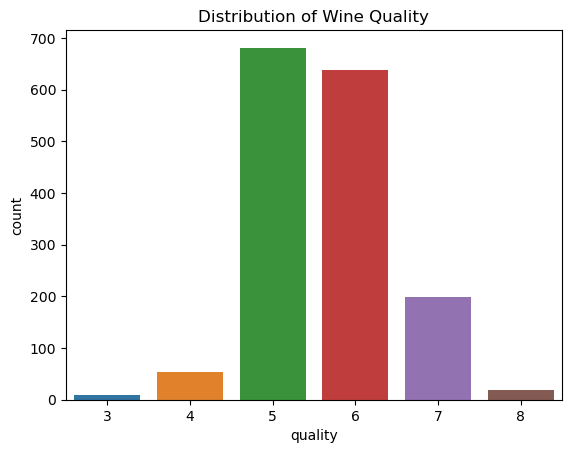

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
from sklearn.svm import SVC

# Load the wine quality dataset
wine_data = pd.read_csv('wine_quality.csv', sep=';')

# Display the first few rows and the information about the dataset
print(wine_data.head())
print(wine_data.info())

# Plot the distribution of wine quality
sns.countplot(x='quality', data=wine_data)
plt.title('Distribution of Wine Quality')
plt.show()


## Motivating Support Vector Machines

As part of our disussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

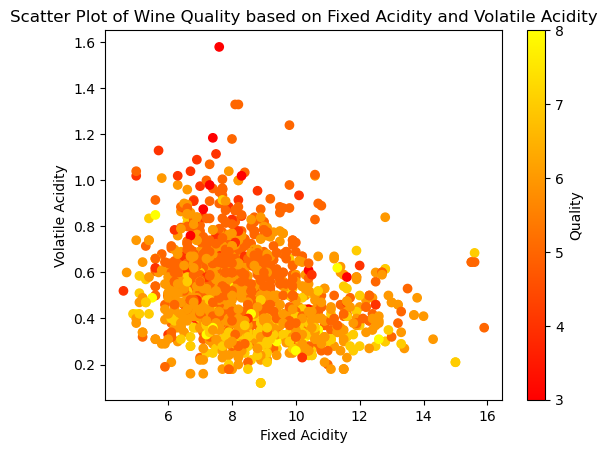

In [18]:
plt.scatter(wine_data['fixed acidity'], wine_data['volatile acidity'], c=wine_data['quality'], cmap='autumn')
plt.xlabel('Fixed Acidity')
plt.ylabel('Volatile Acidity')
plt.title('Scatter Plot of Wine Quality based on Fixed Acidity and Volatile Acidity')
plt.colorbar(label='Quality')
plt.show()

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

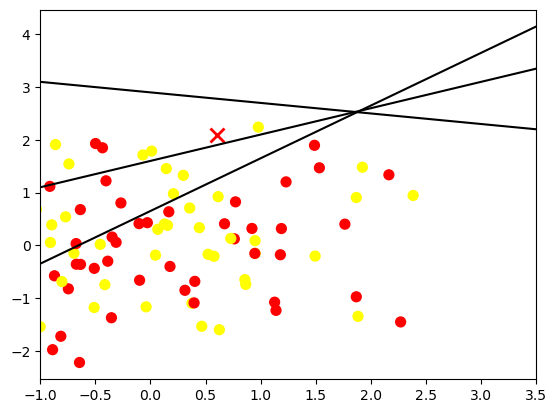

In [19]:
np.random.seed(0)
X = np.random.randn(100, 2)  # Generating random 2D data
y = np.random.randint(0, 2, 100)  # Random labels (binary classification)

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.show()

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

C:\CollegeWork\anac\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


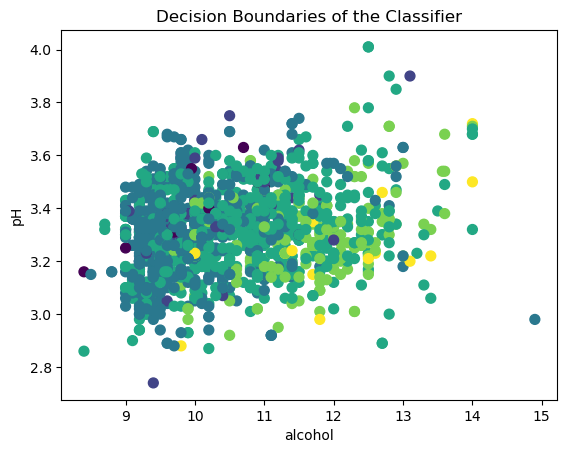

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Assuming 'fixed acidity' and 'volatile acidity' as the features
selected_features = ['alcohol', 'pH']
X = wine_data[selected_features]
y = wine_data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Decision Tree Classifier in this example)
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Plot the decision boundaries
xfit = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 100)
yfit = np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 100)
Xfit, Yfit = np.meshgrid(xfit, yfit)
Z = classifier.predict(np.c_[Xfit.ravel(), Yfit.ravel()])
Z = Z.reshape(Xfit.shape)

#plt.contourf(Xfit, Yfit, Z, alpha=0.4)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='viridis')
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundaries of the Classifier')
plt.show()


In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [21]:
from sklearn.svm import SVC # "Support vector classifier"
X = wine_data[['alcohol', 'pH']].values
y = wine_data['quality'].values

# Train the Support Vector Classifier model
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

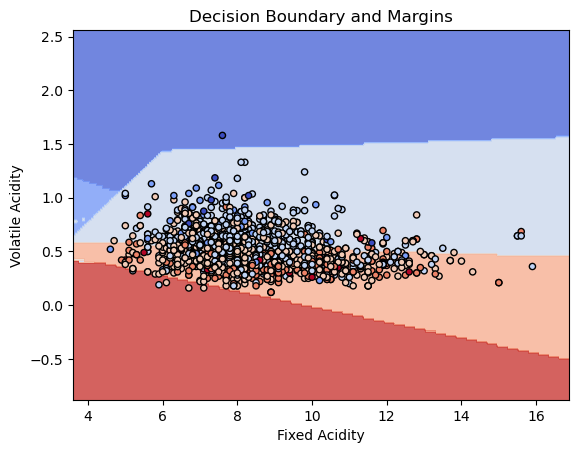

In [22]:
X = wine_data[['fixed acidity', 'volatile acidity']].values
y = wine_data['quality'].values

# Train the SVC model
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

# Define a function to plot decision boundary and margins
def plot_decision_boundary(X, y, model):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.xlabel('Fixed Acidity')
    plt.ylabel('Volatile Acidity')
    plt.title('Decision Boundary and Margins')
    plt.show()

# Plot decision boundary and margins
plot_decision_boundary(X, y, model)

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [24]:
model.support_vectors_

array([[11.6  ,  0.58 ],
       [10.4  ,  0.61 ],
       [ 7.4  ,  1.185],
       ...,
       [ 7.2  ,  0.33 ],
       [ 7.2  ,  0.38 ],
       [ 7.4  ,  0.36 ]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [25]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [29]:
# Select 'fixed acidity' and 'volatile acidity' for X, 'alcohol' for r, and 'quality' for y
X = wine_data[['fixed acidity', 'volatile acidity']].values
r = wine_data['alcohol'].values
y = wine_data['quality'].values

# Fitting a classifier just for the sake of completing the code snippet,
# as we won't be able to plot decision boundaries for 3D scatter plot easily
clf = SVC(kernel='linear')
clf.fit(X, y)

# Define the plotting function
def plot_3D(elev=30, azim=30, X=X, y=y, r=r):
    ax = plt.subplot(projection='3d')
    # Scatter plot for 3D data
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('Fixed Acidity')
    ax.set_ylabel('Volatile Acidity')
    ax.set_zlabel('Alcohol')

# Call the interact function to make the plot interactive
# Note: This will only work in a Jupyter notebook environment with the appropriate backend.
interact(plot_3D, elev=[-90, 90], azim=(-180, 180), X=fixed(X), y=fixed(y), r=fixed(r))

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

<function __main__.plot_3D(elev=30, azim=30, X=array([[7.4  , 0.7  ],
       [7.8  , 0.88 ],
       [7.8  , 0.76 ],
       ...,
       [6.3  , 0.51 ],
       [5.9  , 0.645],
       [6.   , 0.31 ]]), y=array([5, 5, 5, ..., 6, 5, 6], dtype=int64), r=array([ 9.4,  9.8,  9.8, ..., 11. , 10.2, 11. ]))>

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Load the dataset
wine_data = pd.read_csv('wine_quality.csv', delimiter=';')

# Select two features for the SVM input
X = wine_data[['fixed acidity', 'volatile acidity']].values
y = wine_data['quality'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the SVC with RBF kernel
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X_scaled, y)

# Define the plot_svc_decision_function if not already defined
def plot_svc_decision_function(clf, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Creating mesh to plot in
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    
    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # Plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

# Plotting the scaled features, decision boundary, and support vectors
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none')
plt.show()

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

In [35]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

In [ ]:
# X, y = make_blobs(n_samples=100, centers=2,
#                   random_state=0, cluster_std=1.2)
# plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

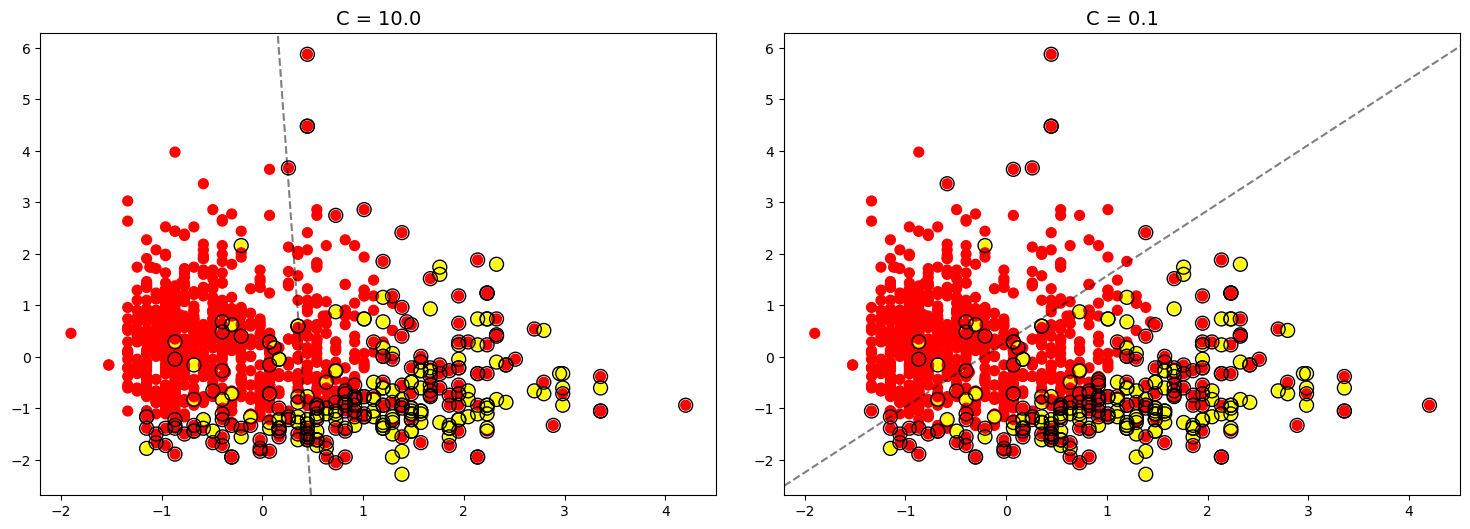

In [36]:
# Load the dataset
wine_data = pd.read_csv('wine_quality.csv', delimiter=';')

# Select two features for visualization and the target variable
X = wine_data[['alcohol', 'volatile acidity']].values
y = wine_data['quality'].values

# Convert to binary classification for visualization purposes
# Define wines with quality 7 and above as high quality (1) and the rest as low quality (0)
y_binary = (y > 6).astype(int)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.3, random_state=42)

# Define the plot_svc_decision_function if not already defined
def plot_svc_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    
    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # Plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

# Train SVM with different C values
C_values = [10.0, 0.1]
models = []

# Fit models with different C values and store them
for C_value in C_values:
    model = SVC(kernel='linear', C=C_value)
    model.fit(X_train, y_train)
    models.append(model)

# Plot the decision boundary for each C value
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for ax, model, C in zip(axes, models, C_values):
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
    plot_svc_decision_function(model, ax)
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=300, lw=1, facecolors='none')
    ax.set_title(f'C = {C}', size=14)

plt.show()

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [37]:
# from sklearn.datasets import fetch_lfw_people
# faces = fetch_lfw_people(min_faces_per_person=60)
# print(faces.target_names)
# print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


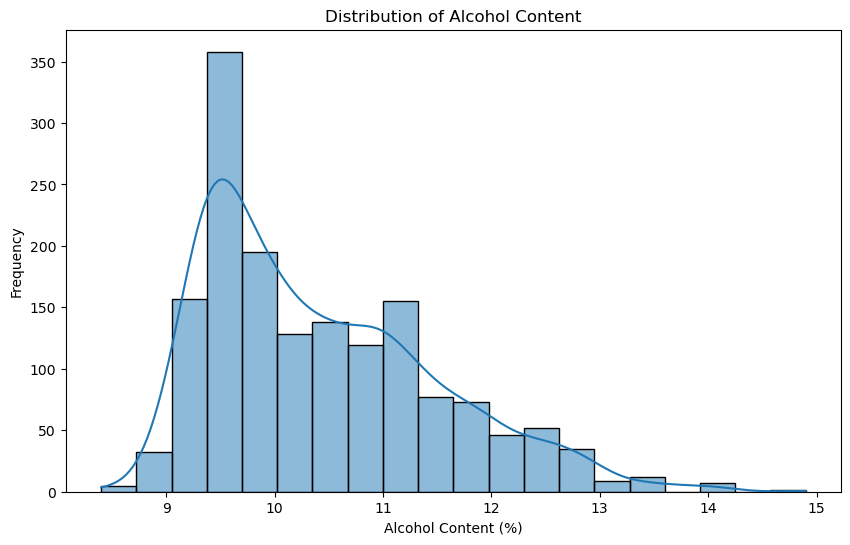

C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\CollegeWork\anac\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


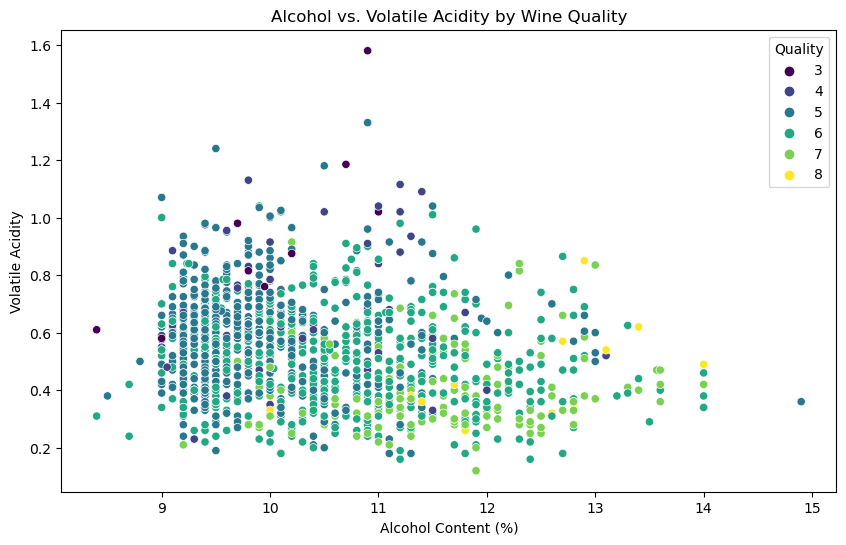

In [41]:
# Plotting distributions of 'alcohol' content *******************Mention u had to replace face recognition with this
plt.figure(figsize=(10, 6))
sns.histplot(wine_data['alcohol'], kde=True, bins=20)
plt.title('Distribution of Alcohol Content')
plt.xlabel('Alcohol Content (%)')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of 'alcohol' vs. 'volatile acidity' colored by 'quality'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='alcohol', y='volatile acidity', hue='quality', data=wine_data, palette='viridis')
plt.title('Alcohol vs. Volatile Acidity by Wine Quality')
plt.xlabel('Alcohol Content (%)')
plt.ylabel('Volatile Acidity')
plt.legend(title='Quality')
plt.show()

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [43]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA  # Updated import
from sklearn.pipeline import make_pipeline

# Use PCA with svd_solver='randomized'
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)


Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [54]:
from sklearn.pipeline import Pipeline
# Select features and target
X = wine_data[['citric acid', 'residual sugar']]
y = wine_data['quality']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Parameter grid for GridSearchCV
param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}

# Grid search for hyperparameter tuning
grid = GridSearchCV(pipe, param_grid, cv=5)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

# Evaluate on the test set (optional)
print("Test set score:", grid.score(X_test, y_test))

Best parameters: {'svc__C': 50, 'svc__gamma': 0.001}
Test set score: 0.44375


Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
